In [56]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%load_ext autoreload
%autoreload 2

import _init_paths
import os
import sys
import numpy as np
import argparse
import pprint
import time
import cv2
import pickle
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import pickle
from roi_data_layer.roibatchLoader import roibatchLoader
from model.utils.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from model.rpn.twin_transform import clip_twins
from model.nms.nms_wrapper import nms
from model.rpn.twin_transform import twin_transform_inv
from model.utils.net_utils import save_net, load_net, vis_detections
from model.tdcnn.c3d import C3D
from model.tdcnn.c3d_fewshot import C3D, c3d_tdcnn_fewshot
from model.tdcnn.i3d import I3D, i3d_tdcnn
from model.utils.blob import prep_im_for_blob, video_list_to_blob
from model.tdcnn.resnet import resnet34, resnet50, resnet_tdcnn
from os.path import exists
from trainval_fewshot_net import create_sampled_support_set_dataset

# np.set_printoptions(threshold='nan')
DEBUG = False

xrange = range  # Python 3


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
def parse_args():
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description='Test a R-C3D network')
    parser.add_argument('--dataset', dest='dataset', default='thumos14', type=str,
                        help='test dataset')
    parser.add_argument('--net', dest='net', default='c3d', type=str, choices=['c3d', 'res18', 'res34', 'res50', 'eco'],
                        help='main network c3d, i3d, res34, res50')
    parser.add_argument('--set', dest='set_cfgs', nargs=argparse.REMAINDER,
                        help='set config keys', default=None)
    parser.add_argument('--load_dir', dest='load_dir', type=str,
                        help='directory to load models', default="./models")
    parser.add_argument('--output_dir', dest='output_dir', type=str,
                        help='directory for the log files', default="./output")
    parser.add_argument('--cuda', dest='cuda', action='store_true',
                        help='whether use CUDA')
    parser.add_argument('--checksession', default=1, type=int,
                        help='checksession to load model')
    parser.add_argument('--checkepoch', default=1, type=int,
                        help='checkepoch to load network')
    parser.add_argument('--checkpoint', default=9388, type=int,
                        help='checkpoint to load network')
    parser.add_argument('--nw', dest='num_workers', default=8, type=int,
                        help='number of worker to load data')
    parser.add_argument('--bs', dest='batch_size', default=1, type=int,
                        help='batch_size, only support batch_size=1')
    parser.add_argument('--vis', dest='vis', action='store_true',
                        help='visualization mode')
    parser.add_argument('--roidb_dir', dest='roidb_dir', default="./preprocess",
                        help='roidb_dir')
    parser.add_argument('--gpus', dest='gpus', nargs='+', type=int, default=0,
                        help='gpu ids.')
    manual_args = '--net c3d --dataset thumos14 --cuda --gpus 0 1 2 3 --bs 4 --nw 8 --checksession 1 --checkepoch 2 --checkpoint 1960'.split(' ')
    args = parser.parse_args(manual_args)
    return args

In [58]:
def get_roidb(path):
    data = pickle.load(open(path, 'rb'))
    return data


combined_pooled_feat = []


def comp_pairwise_dist():
    num_vecs = len(combined_pooled_feat)
    dist = np.zeros([num_vecs, num_vecs])
    for i in range(num_vecs):
        for j in range(num_vecs):
            dist[i][j] = torch.norm(combined_pooled_feat[i] - combined_pooled_feat[j])
        sorted_vals, sorted_idx = torch.sort(torch.Tensor(dist[i]))
        print('Those closest to %d are %s' % (i, str(sorted_idx[:5])))

In [59]:
args = parse_args()

print('Called with args:')
print(args)

cudnn.benchmark = True
if torch.cuda.is_available() and not args.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

np.random.seed(cfg.RNG_SEED)
if args.dataset == "thumos14":
    # args.imdb_name = "train_data_25fps_flipped.pkl"
    args.imdbval_name = "val_data_25fps.pkl"
    args.num_classes = 21
    args.set_cfgs = ['ANCHOR_SCALES', '[2,4,5,6,8,9,10,12,14,16]', 'NUM_CLASSES', args.num_classes]
    # args.set_cfgs = ['ANCHOR_SCALES', '[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56]', 'NUM_CLASSES', args.num_classes]
elif args.dataset == "activitynet":
    # args.imdb_name = "train_data_5fps_flipped.pkl"
    args.imdbval_name = "val_data_25fps.pkl"
    args.num_classes = 201
    # args.set_cfgs = ['ANCHOR_SCALES', '[1,2,3,4,5,6,7,8,10,12,14,16,20,24,28,32,40,48,56,64]', 'NUM_CLASSES', args.num_classes]
    args.set_cfgs = ['ANCHOR_SCALES',
                     '[1,1.25, 1.5,1.75, 2,2.5, 3,3.5, 4,4.5, 5,5.5, 6,7, 8,9,10,11,12,14,16,18,20,22,24,28,32,36,40,44,52,60,68,76,84,92,100]',
                     'NUM_CLASSES', args.num_classes]

args.cfg_file = "cfgs/{}_{}.yml".format(args.net, args.dataset)

if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)
if args.set_cfgs is not None:
    cfg_from_list(args.set_cfgs)

cfg.USE_GPU_NMS = args.cuda
cfg.CUDA = args.cuda

print('Using config:')
pprint.pprint(cfg)

trimmed_support_set_roidb_path = os.path.join(args.roidb_dir, args.dataset, "trimmed_14_cls.pkl")
trimmed_support_set_roidb = get_roidb(trimmed_support_set_roidb_path)

untrimmed_test_roidb_path = args.roidb_dir + "/" + args.dataset + "/" + args.imdbval_name
untrimmed_test_roidb = get_roidb(untrimmed_test_roidb_path)
untrimmed_test_dataset = roibatchLoader(untrimmed_test_roidb, phase='test')
untrimmed_test_dataloader = torch.utils.data.DataLoader(untrimmed_test_dataset, batch_size=args.batch_size,
                                         num_workers=args.num_workers, shuffle=False)


Called with args:
Namespace(batch_size=4, checkepoch=2, checkpoint=1960, checksession=1, cuda=True, dataset='thumos14', gpus=[0, 1, 2, 3], load_dir='./models', net='c3d', num_workers=8, output_dir='./output', roidb_dir='./preprocess', set_cfgs=None, vis=False)
Using config:
{'ANCHOR_SCALES': [2, 4, 5, 6, 8, 9, 10, 12, 14, 16],
 'CUDA': True,
 'DATA_DIR': '/home/vltava/few-shot-activity-localization/rc3d-chen/data',
 'DEDUP_TWINS': 0.125,
 'EPS': 1e-14,
 'EXP_DIR': 'default',
 'FEAT_STRIDE': [8],
 'INPUT': 'video',
 'MAX_NUM_GT_TWINS': 20,
 'NUM_CLASSES': 21,
 'PIXEL_MEANS': array([[[ 90,  98, 102]]]),
 'PIXEL_MEANS_FLOW': array([128]),
 'POOLING_HEIGHT': 2,
 'POOLING_LENGTH': 4,
 'POOLING_MODE': 'pool',
 'POOLING_WIDTH': 2,
 'RESNET': {'FIXED_BLOCKS': 0, 'MAX_POOL': False},
 'RNG_SEED': 3,
 'ROI_CTX_SCALE': [],
 'ROOT_DIR': '/home/vltava/few-shot-activity-localization/rc3d-chen',
 'RPN_HAS_MASK': False,
 'RPN_OUTPUT_SCORE': False,
 'TEMP_SPARSE_SAMPLING': False,
 'TEST': {'NMS': 0.4,
 

/home/vltava/few-shot-activity-localization/rc3d-chen/lib/model/utils/config.py:375: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


In [60]:
num_videos = len(untrimmed_test_dataset)
args.num_videos = num_videos
print('{:d} roidb entries'.format(num_videos))

model_dir = args.load_dir + "/" + args.net + "/" + args.dataset
if not os.path.exists(model_dir):
    raise Exception('There is no input directory for loading network from ' + model_dir)
output_dir = args.output_dir + "/" + args.net + "/" + args.dataset
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
load_name = os.path.join(model_dir, 'tdcnn_{}_{}_{}.pth'.format(args.checksession, args.checkepoch, args.checkpoint))
# load_name = '/home/vltava/few-shot-activity-localization/rc3d-chen/models/c3d/thumos14/without_metatraining_models/tdcnn_1_7_1960.pth'

# initilize the network here.
if args.net == 'c3d':
    tdcnn_demo = c3d_tdcnn_fewshot(pretrained=False)
elif args.net == 'res18':
    tdcnn_demo = resnet_tdcnn(depth=18, pretrained=False)
elif args.net == 'res34':
    tdcnn_demo = resnet_tdcnn(depth=34, pretrained=False)
elif args.net == 'res50':
    tdcnn_demo = resnet_tdcnn(depth=50, pretrained=False)
else:
    print("network is not defined")

tdcnn_demo.create_architecture()
# save memory
for key, value in tdcnn_demo.named_parameters(): value.requires_grad = False
print(tdcnn_demo)

print("load checkpoint %s" % (load_name))
checkpoint = torch.load(load_name)
tdcnn_demo.load_state_dict(checkpoint['model'])
if 'pooling_mode' in checkpoint.keys():
    cfg.POOLING_MODE = checkpoint['pooling_mode']
    print('load model successfully!')

if args.cuda and torch.cuda.is_available():
    tdcnn_demo = tdcnn_demo.cuda()
    if isinstance(args.gpus, int):
        args.gpus = [args.gpus]
    # assert len(args.gpus) == args.batch_size, "only support one batch_size for one gpu"
    tdcnn_demo = nn.parallel.DataParallel(tdcnn_demo, device_ids=args.gpus)

12766 roidb entries
cfg.POOLING_LENGTH: 4
c3d_tdcnn_fewshot(
  (RCNN_rpn): _RPN(
    (RPN_Conv1): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (RPN_Conv2): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (RPN_output_pool): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (RPN_cls_score): Conv3d(512, 20, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (RPN_twin_pred): Conv3d(512, 20, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (RPN_proposal): _ProposalLayer()
    (RPN_anchor_target): _AnchorTargetLayer()
  )
  (RCNN_proposal_target): _ProposalTargetLayer()
  (RCNN_roi_temporal_pool): _RoITemporalPooling()
  (RCNN_base): Sequential(
    (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU(inplace)
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(64, 128, kernel_size=(3, 3

In [61]:
from os.path import exists

FEWSHOT_FEATURES_PATH = '/home/vltava/fewshot_features_5_shot.pkl'

dataloader = untrimmed_test_dataloader

start = time.time()
# TODO: Add restriction for max_per_video
max_per_video = 0

thresh = 0.9

all_twins = [[[] for _ in xrange(args.num_videos)]
             for _ in xrange(args.num_classes)]

_t = {'im_detect': time.time(), 'misc': time.time()}

tdcnn_demo.eval()
empty_array = np.transpose(np.array([[], [], []]), (1, 0))

if exists(FEWSHOT_FEATURES_PATH):
    all_fewshot_features = pickle.load(open(FEWSHOT_FEATURES_PATH, 'rb'))
else:
    support_set_dataloader = create_sampled_support_set_dataset(trimmed_support_set_roidb,
                                                                [2, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19],
                                                                batch_size=args.batch_size,
                                                                num_workers=args.num_workers,
                                                                samples_per_class=5)
    print('Loading fewshot trimmed videos')
    feature_vectors = []
    feature_labels = []
    for _, (video_data, gt_twins, _) in enumerate(support_set_dataloader):
        support_set_features, support_set_labels = \
            tdcnn_demo(video_data, None, None, gt_twins, True)
        feature_vectors.append(support_set_features)
        feature_labels.append(support_set_labels)
        del video_data
    all_fewshot_features = (torch.cat(feature_vectors), torch.cat(feature_labels))

    pickle.dump(all_fewshot_features, open(FEWSHOT_FEATURES_PATH, 'wb'))

support_set_features = all_fewshot_features[0]
support_set_labels = all_fewshot_features[1]

print(f'Got {support_set_features.shape[0]} few shot features')
print(f'Labels: {support_set_labels}')
print(f'Features shape: {support_set_features.shape}')

Got 70 few shot features
Labels: tensor([  2,   2,   2,   2,   2,   4,   4,   4,   4,   4,   6,   6,
          6,   6,   6,   7,   7,   7,   7,   7,   8,   8,   8,   8,
          8,   9,   9,   9,   9,   9,  10,  10,  10,  10,  10,  12,
         12,  12,  12,  12,  13,  13,  13,  13,  13,  14,  14,  14,
         14,  14,  15,  15,  15,  15,  15,  16,  16,  16,  16,  16,
         18,  18,  18,  18,  18,  19,  19,  19,  19,  19], device='cuda:0')
Features shape: torch.Size([70, 4096])


In [22]:
torch.sort(torch.nn.functional.cosine_similarity(support_set_features[40].unsqueeze(0), support_set_features), descending=True)

(tensor([ 1.0000,  0.6990,  0.6664,  0.6566,  0.6225,  0.5920,  0.5891,
          0.5879,  0.5705,  0.5698,  0.5659,  0.5335,  0.5323,  0.5180,
          0.5099,  0.5031,  0.4966,  0.4729,  0.4729,  0.4718,  0.4689,
          0.4681,  0.4302,  0.4218,  0.4160,  0.4118,  0.4107,  0.4103,
          0.4078,  0.4077,  0.4074,  0.3997,  0.3974,  0.3925,  0.3882,
          0.3852,  0.3830,  0.3760,  0.3758,  0.3682,  0.3643,  0.3627,
          0.3606,  0.3553,  0.3426,  0.3390,  0.3259,  0.3156,  0.3155,
          0.3126,  0.2952,  0.2887,  0.2844,  0.2821,  0.2795,  0.2708,
          0.2690,  0.2589,  0.2526,  0.2516,  0.2492,  0.2453,  0.2417,
          0.2391,  0.2332,  0.2229,  0.2201,  0.2153,  0.2099,  0.1954], device='cuda:0'),
 tensor([ 40,  47,  43,  39,  37,  46,  51,  48,  45,  44,  49,  35,
          11,  69,  50,  38,  14,  25,  29,  26,  59,  55,  12,  53,
          36,   4,  27,  13,  66,   0,  62,  20,  60,  30,  57,  65,
          54,   1,  68,   2,  15,   3,  63,  41,  42, 

(70,)


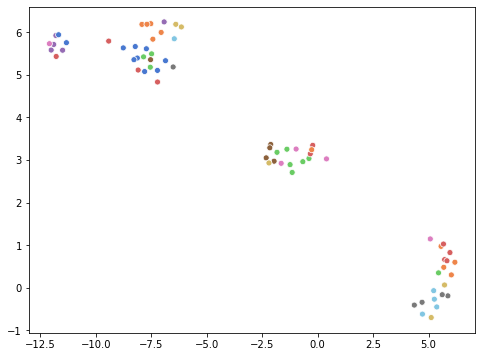

In [55]:
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import umap

reducer = umap.UMAP(metric='cosine')
embedding = reducer.fit_transform(support_set_features)

# distance_matrix = pairwise_distances(support_set_features, support_set_features, metric='cosine', n_jobs=-1)
# model = TSNE(metric="precomputed", perplexity=60)
# Xpr = model.fit_transform(distance_matrix)

plot_data = {}
plot_data['y'] = support_set_labels.cpu().numpy()
print(plot_data['y'].shape)
plot_data['x1'] = embedding[:, 0]
plot_data['x2'] = embedding[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="x1", y="x2",
    hue="y",
    palette=sns.color_palette("muted", 14),
    data=plot_data,
    legend=False
)

In [27]:
data_tic = time.time()
print(f'Start time: {data_tic}')
for i, (video_data, gt_twins, num_gt, video_info) in enumerate(dataloader):
    video_data = video_data.cuda()
    gt_twins = gt_twins.cuda()
    batch_size = video_data.shape[0]
    data_toc = time.time()
    data_time = data_toc - data_tic

    det_tic = time.time()
    rois, cls_prob, twin_pred, fewshot_scores = \
        tdcnn_demo(video_data,
                   torch.cat(args.batch_size * [support_set_features.unsqueeze(0)]),
                   torch.cat(args.batch_size * [support_set_labels.unsqueeze(0)]),
                   gt_twins)

    scores_all = fewshot_scores.data
    twins = rois.data[:, :, 1:3]

    if cfg.TEST.TWIN_REG:
        # Apply bounding-twin regression deltas
        twin_deltas = twin_pred.data
        if cfg.TRAIN.TWIN_NORMALIZE_TARGETS_PRECOMPUTED:
            # Optionally normalize targets by a precomputed mean and stdev
            twin_deltas = twin_deltas.view(-1, 2) * torch.FloatTensor(cfg.TRAIN.TWIN_NORMALIZE_STDS).type_as(
                twin_deltas) \
                          + torch.FloatTensor(cfg.TRAIN.TWIN_NORMALIZE_MEANS).type_as(twin_deltas)
            twin_deltas = twin_deltas.view(batch_size, -1, 2 * args.num_classes)

        pred_twins_all = twin_transform_inv(twins, twin_deltas, batch_size)
        pred_twins_all = clip_twins(pred_twins_all, cfg.TRAIN.LENGTH[0], batch_size)
    else:
        # Simply repeat the twins, once for each class
        pred_twins_all = np.tile(twins, (1, scores_all.shape[1]))

    det_toc = time.time()
    detect_time = det_toc - det_tic

    for b in range(batch_size):
        misc_tic = time.time()
        print(video_info[b])
        # cls_prob scores are not helpful for fewshot since these are 21-class output (0 = background)
        # and the new example doesn't appear in the training data
        pred_twins = pred_twins_all[b]  # .squeeze()

        fewshot_scores_of_batch = fewshot_scores[b]

        # skip j = 0, because it's the background class
        for j in range(fewshot_scores_of_batch.shape[1]):
            inds = torch.nonzero(fewshot_scores_of_batch[:, j] > thresh).view(-1)

            # if there is detection
            if inds.numel() > 0:
                cls_scores = fewshot_scores_of_batch[:, j][inds]
                _, order = torch.sort(cls_scores, 0, True)
                cls_twins = pred_twins[inds][:, j * 2:(j + 1) * 2]

                cls_dets = torch.cat((cls_twins, cls_scores.unsqueeze(1)), 1)
                cls_dets = cls_dets[order]
                keep = nms(cls_dets, cfg.TEST.NMS)
                if len(keep) > 0:
                    cls_dets = cls_dets[keep.view(-1).long()]
                    print("activity: ", support_set_labels[j].item())
                    print(cls_dets.cpu().numpy())

                all_twins[j][i * batch_size + b] = cls_dets.cpu().numpy()
            else:
                all_twins[j][i * batch_size + b] = empty_array

        # Limit to max_per_video detections *over all classes*
        if max_per_video > 0:
            video_scores = np.hstack([all_twins[j][i * batch_size + b][:, -1]
                                      for j in xrange(1, args.num_classes)])
            if len(video_scores) > max_per_video:
                video_thresh = np.sort(video_scores)[-max_per_video]
                for j in xrange(1, args.num_classes):
                    keep = np.where(all_twins[j][i * batch_size + b][:, -1] >= video_thresh)[0]
                    all_twins[j][i * batch_size + b] = all_twins[j][i * batch_size + b][keep, :]

        misc_toc = time.time()
        nms_time = misc_toc - misc_tic
        print('im_detect: {:d}/{:d} {:.3f}s {:.3f}s {:.3f}s' \
              .format(i * batch_size + b + 1, args.num_videos, data_time / batch_size, detect_time / batch_size,
                      nms_time))

    if args.vis:
        pass

    data_tic = time.time()
end = time.time()
print("test time: %0.4fs" % (end - start))

torch.Size([4, 3, 768, 112, 112])
(' flipped: False\n frames: [[  0   0 768   1]]\n bg_name: /home/vltava/disk2/THUMOS14_valtest_combined_fewshot/frames/test/video_validation_0000901\n fg_name: /home/vltava/disk2/THUMOS14_valtest_combined_fewshot/frames/test/video_validation_0000901', ' flipped: False\n frames: [[  0 192 960   1]]\n bg_name: /home/vltava/disk2/THUMOS14_valtest_combined_fewshot/frames/test/video_validation_0000901\n fg_name: /home/vltava/disk2/THUMOS14_valtest_combined_fewshot/frames/test/video_validation_0000901', ' flipped: False\n frames: [[   0  384 1152    1]]\n bg_name: /home/vltava/disk2/THUMOS14_valtest_combined_fewshot/frames/test/video_validation_0000901\n fg_name: /home/vltava/disk2/THUMOS14_valtest_combined_fewshot/frames/test/video_validation_0000901', ' flipped: False\n frames: [[   0  576 1344    1]]\n bg_name: /home/vltava/disk2/THUMOS14_valtest_combined_fewshot/frames/test/video_validation_0000901\n fg_name: /home/vltava/disk2/THUMOS14_valtest_combined_

In [26]:
fewshot_pred

(tensor([ 0.9391,  0.9401,  0.8988,  ...,  0.9115,  0.9487,  0.9382], device='cuda:0'),
 tensor([ 0,  0,  0,  ...,  0,  0,  0], device='cuda:0'))

Populating the interactive namespace from numpy and matplotlib


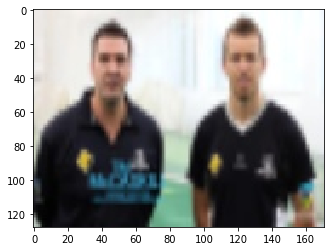

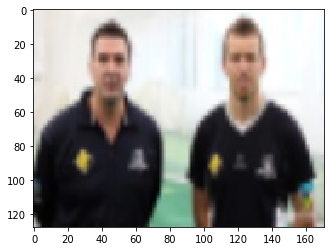

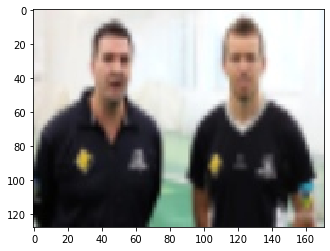

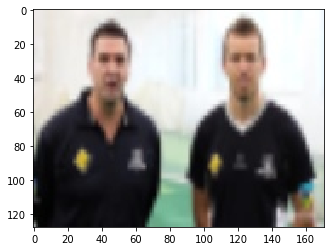

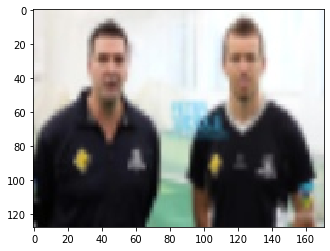

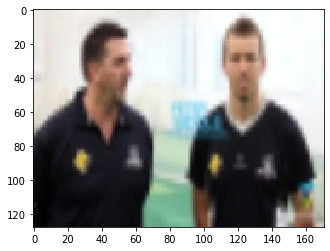

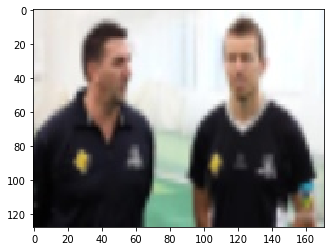

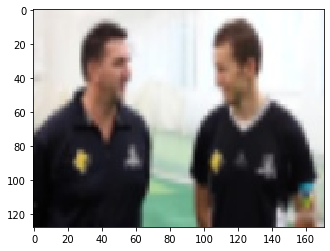

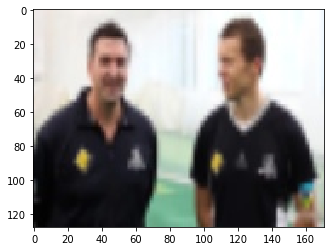

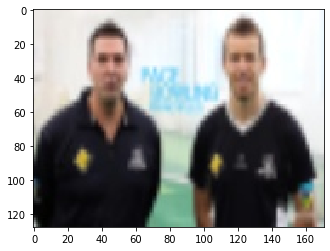

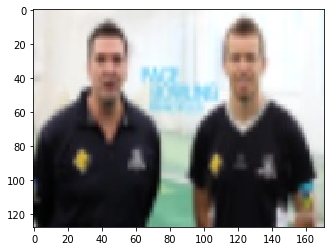

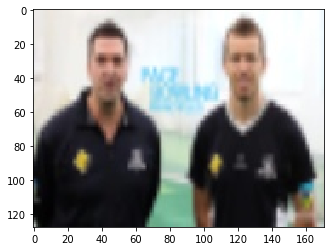

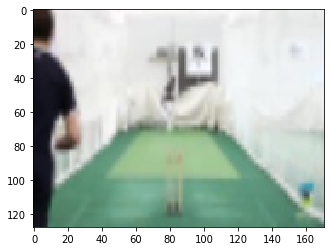

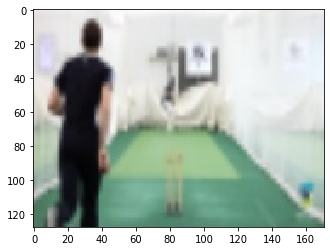

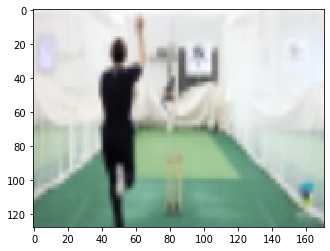

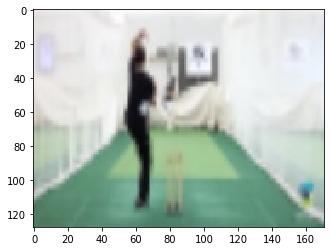

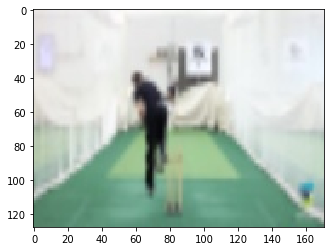

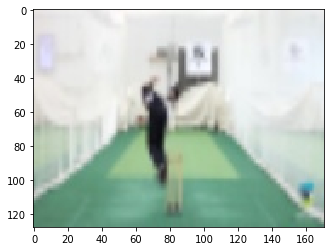

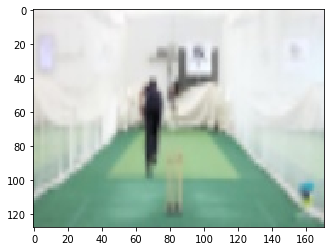

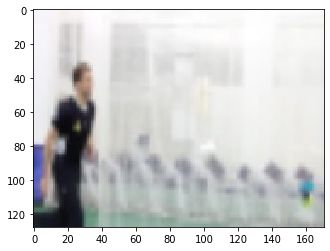

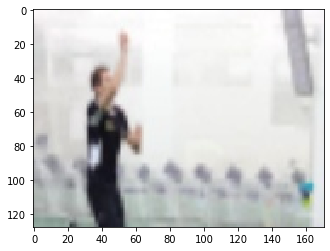

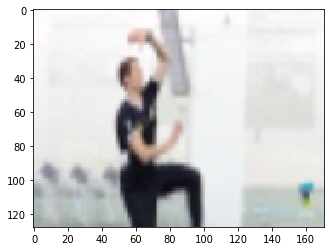

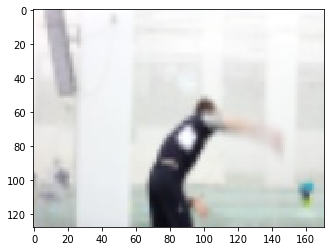

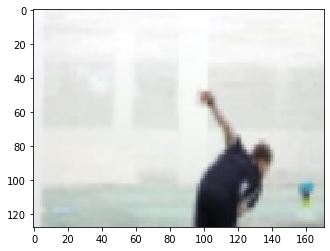

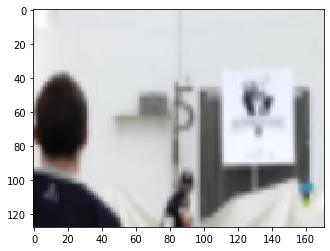

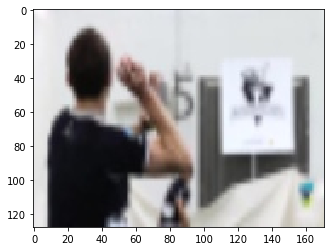

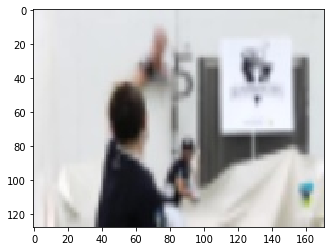

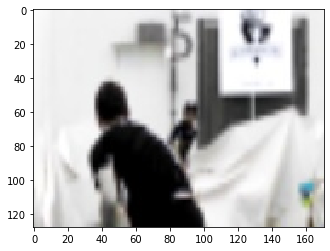

In [20]:
%pylab inline
import cv2
import matplotlib.pyplot as plt
from os.path import join

folder = '/home/vltava/disk2/THUMOS14_valtest_combined_fewshot/frames/test/video_test_0001313/'
for i in range(10, 38):
    im = cv2.imread(join(folder, f'image_00{i * 20}.jpg'))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.show()